In [39]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [40]:
IMAGE_SIZE = 384
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [41]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DogEmotions",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1603 files belonging to 4 classes.


In [42]:
class_names = dataset.class_names
class_names

['Angry', 'Happy', 'Relaxed', 'Sad']

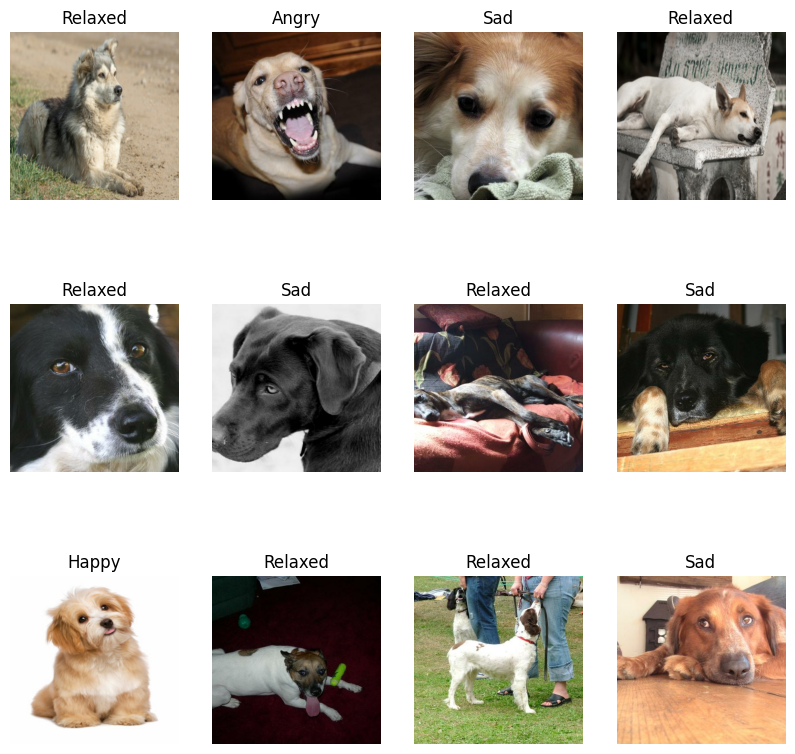

In [43]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [44]:
#Splitting the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [46]:
len(train_ds)

40

In [47]:
len(test_ds)

6

In [48]:
len(val_ds)

5

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
# Data Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [51]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [57]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [58]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (32, 382, 382, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 191, 191, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 189, 189, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 94, 94, 64)         0         
 g2D)                                                 

In [59]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
40/40 [==============================] - 604s 15s/step - loss: 1.3894 - accuracy: 0.2518 - val_loss: 1.3845 - val_accuracy: 0.3438
Epoch 2/10
40/40 [==============================] - 484s 12s/step - loss: 1.3854 - accuracy: 0.2694 - val_loss: 1.3751 - val_accuracy: 0.3562
Epoch 3/10
40/40 [==============================] - 440s 11s/step - loss: 1.3665 - accuracy: 0.2838 - val_loss: 1.3688 - val_accuracy: 0.3313
Epoch 4/10
40/40 [==============================] - 417s 10s/step - loss: 1.3531 - accuracy: 0.3141 - val_loss: 1.3670 - val_accuracy: 0.3438
Epoch 5/10
40/40 [==============================] - 403s 10s/step - loss: 1.3329 - accuracy: 0.3477 - val_loss: 1.3438 - val_accuracy: 0.2937
Epoch 6/10
40/40 [==============================] - 417s 10s/step - loss: 1.3173 - accuracy: 0.3413 - val_loss: 1.3259 - val_accuracy: 0.3562
Epoch 7/10
40/40 [==============================] - 533s 13s/step - loss: 1.3055 - accuracy: 0.3453 - val_loss: 1.3227 - val_accuracy: 0.4000
Epoch 

In [ ]:
# Applying DenseNet201
base_model_dense = tf.keras.applications.DenseNet201(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=True, weights=None, classes=3)

In [ ]:
base_model_dense.trainable = True

In [ ]:
base_learning_rate = 0.0001
base_model_dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
base_model_dense.summary()

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "DogEmotions",
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "DogEmotions",
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = val_test_ds.take(int(0.5 * len(val_test_ds)))
test_ds = val_test_ds.skip(int(0.5 * len(val_test_ds)))

In [ ]:
initial_epochs = 10
results = base_model_dense.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

In [ ]:
acc_aug = results.history['accuracy']
val_acc_aug = results.history['val_accuracy']
loss_aug = results.history['loss']
val_loss_aug = results.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_aug, label='Training Accuracy')
plt.plot(epochs_range, val_acc_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_aug, label='Training Loss')
plt.plot(epochs_range, val_loss_aug, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = base_model_dense.evaluate(test_ds)
print("Test accuracy:", accuracy)

In [ ]:
# use image augmentation with densenet
data_augmentation_dense = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    ])
preprocess_input_dense = tf.keras.applications.densenet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
base_model_dense_aug = tf.keras.applications.DenseNet201(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=True, weights=None, classes=3)

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model_dense_aug(image_batch)
print(feature_batch.shape)

In [ ]:
base_model_dense_aug.trainable = True

In [ ]:
base_learning_rate = 0.0001
base_model_dense_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
history_dense_aug = base_model_dense_aug.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
acc_aug = history_dense_aug.history['accuracy']
val_acc_aug = history_dense_aug.history['val_accuracy']
loss_aug = history_dense_aug.history['loss']
val_loss_aug = history_dense_aug.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_aug, label='Training Accuracy')
plt.plot(epochs_range, val_acc_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_aug, label='Training Loss')
plt.plot(epochs_range, val_loss_aug, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = base_model_dense_aug.evaluate(test_ds)
print("Test accuracy:", accuracy)

In [ ]:
print("Number of layers in the base model: ", len(base_model_dense_aug.layers))

fine_tune_at = 100

for layer in base_model_dense_aug.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
base_model_dense_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])

In [ ]:
total_epochs =  20

history_fine = base_model_dense_aug.fit(train_ds, epochs=total_epochs, initial_epoch=history_dense_aug.epoch[-1], validation_data=val_ds)

In [ ]:
acc_aug = history_fine.history['accuracy']
val_acc_aug = history_fine.history['val_accuracy']
loss_aug = history_fine.history['loss']
val_loss_aug = history_fine.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_aug, label='Training Accuracy')
plt.plot(epochs_range, val_acc_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_aug, label='Training Loss')
plt.plot(epochs_range, val_loss_aug, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = base_model_dense_aug.evaluate(test_ds)
print("Test accuracy:", accuracy)

In [ ]:
base_model_dense_aug.save('../models')

In [ ]:
model = tf.keras.models.load_model('../models')

In [ ]:
predictions = base_model_dense_aug.predict(test_ds)

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
for features, labels in test_ds:
    predictions = model(features, training=False)
    precision.update_state(labels, predictions)
    recall.update_state(labels, predictions)

In [ ]:
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

print("Precision: {:.4f}".format(precision_result))
print("Recall: {:.4f}".format(recall_result))

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

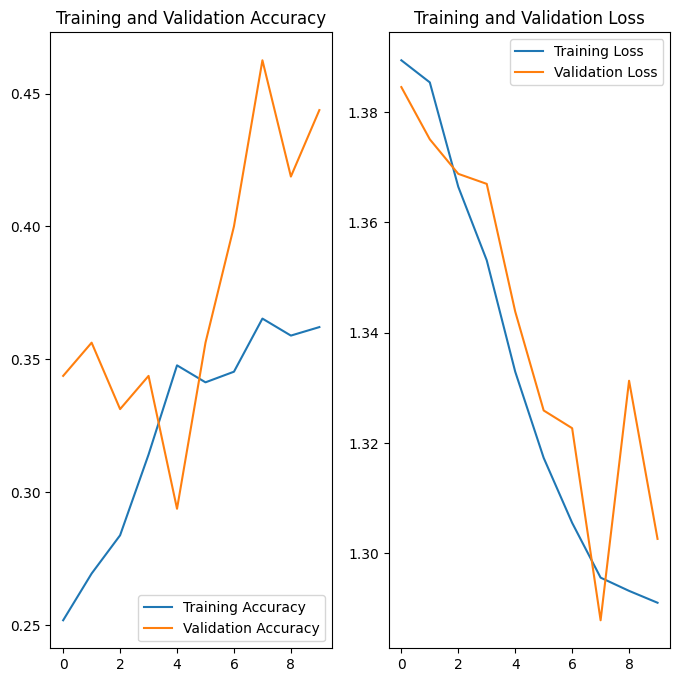

In [65]:
# Training vs Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label : Sad
1/1 [==============================] - 3s 3s/step
Predicted Label : Happy


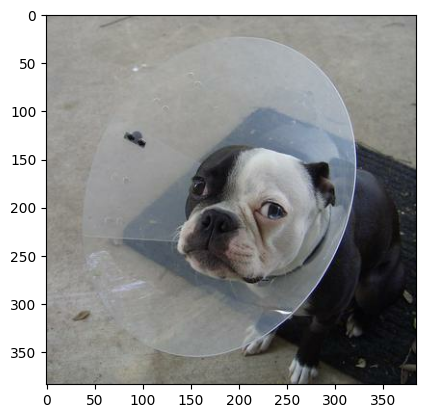

In [66]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label :", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label :", class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 142ms/step


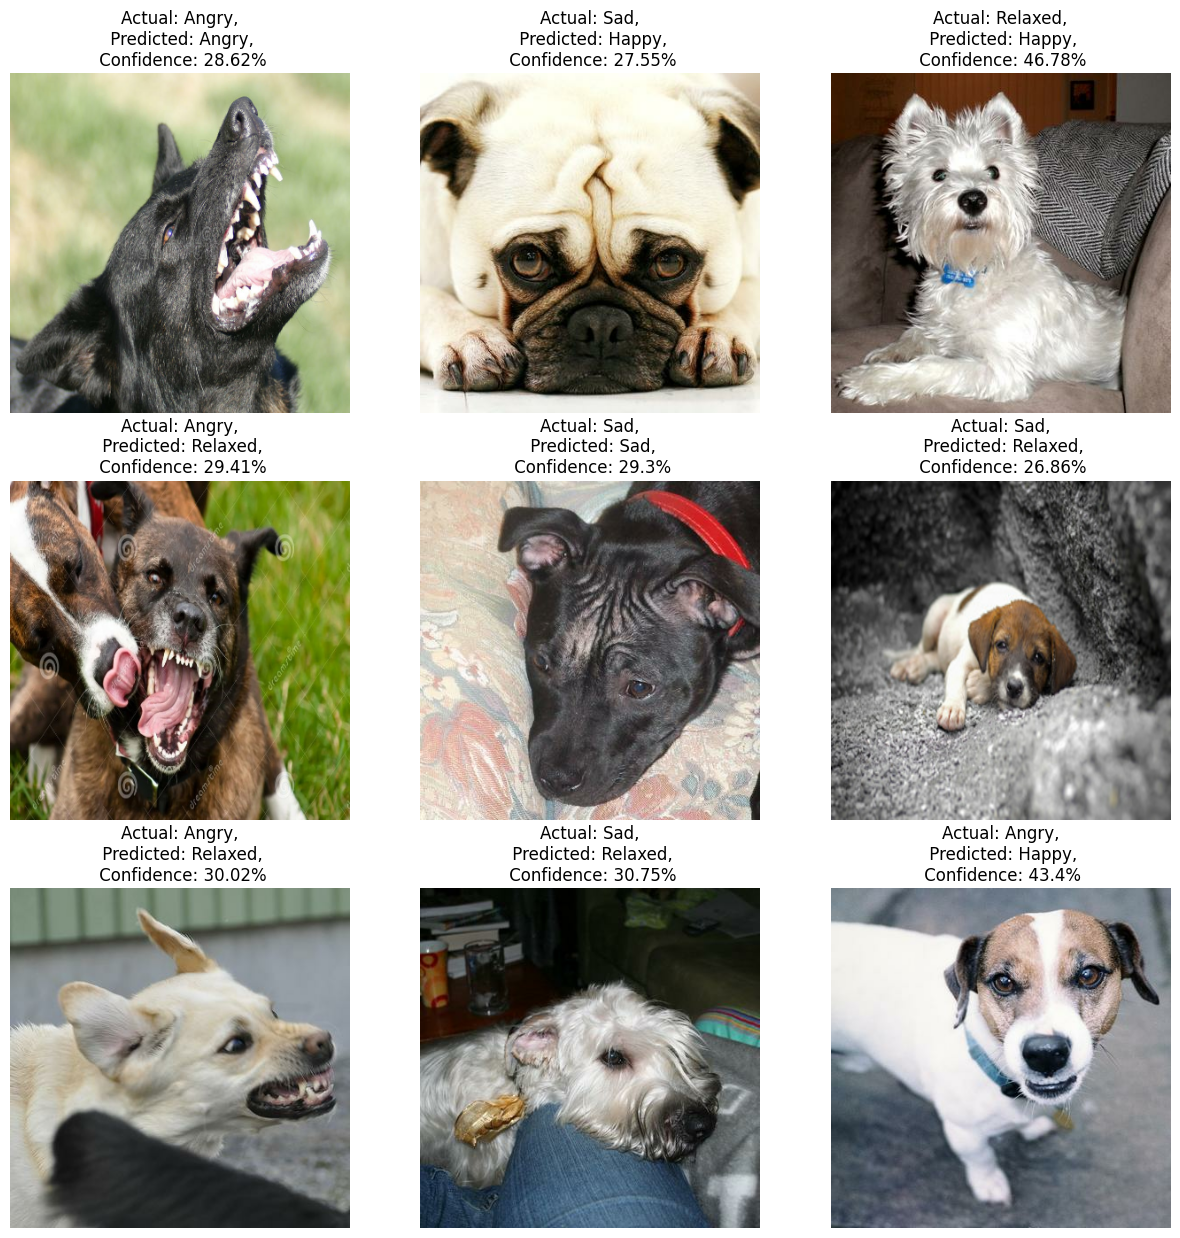

In [67]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Creating a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence